In [1]:
%matplotlib notebook



Working with fNIRS data
=============================================================



Author: Matteo Caffini  
Contact: <matteo.caffini@unitn.it>

In [2]:
import mne
from matplotlib import pyplot as plt
import numpy as np

MNE Python was implemented with EEG and MEG in mind, but can be useful to process fNIRS data as well. A common fNIRS data set (similarly to EEG and MEG data) contains data recorded over time (a.k.a. samples) at many locations on the scalp (a.k.a. channels).  
Usually in fNIRS one looks for brain responses to external sensorial stimulations (visual, acoustic, etc.). In order to do so, block design studies are usually employed and data are later epoched to get evoked responses.

Loading continuous fNIRS data
-----------------------------

fNIRS raw data come in various formats and the best way to dive into MNE is to deal with your own format first and fit your data into a 2D numpy array $[\text{channels} \times \text{samples}]$.  Once you prepared your time series for HbO and HbR concentrations, you can create a RawArray instance from the data array using `RawArray <mne.io.RawArray>`. If you have a time series of events synchronous with your data you can append this as a last row to your array.

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, I don't preprocess the data. If your fNIRS device  outputs data in the form of photon fluences at detectors, you can compute HbO and HbR concentrations using the  modified Lambert-Beer model. See our `tutorials` on preprocessing fNIRS data for more?.</p></div>

Often fNIRS data contain time series for oxyhemoglobin (HbO) and deoxyhemoglobin (HbR) concentrations and you want to process them both. Using the *channel types* field in the `Info <mne.Info>` structure, you can assign either 'hbo' or 'hbr' channel type to your channel.

In the following example we have data from 20 channels plus one events channel and we end up with 20 HbO time series, 20 HbR time series and one events time series.

Let's start by creating a proper Info structure containing metadata about the fNIRS recording.

In [3]:
# Load ndarray with HbO, HbR and events data
raw_ndarray = np.load('/home/matteo/raw_ndarray.npy')

# Create_info
nChannels = 20 # number of physical channels
sampling_frequency = 15.625

channel_names_fnirs = ['HbO '+"%.2d" % i for i in range(1,nChannels+1)] + ['HbR '+"%.2d" % i for i in range(1,nChannels+1)]
channel_names = channel_names_fnirs + ['Events']

channel_types = ['hbo' for i in range(nChannels)] + ['hbr' for i in range(nChannels)] + ['stim']

info = mne.create_info(ch_names=channel_names, sfreq=sampling_frequency, ch_types=channel_types, montage=None)
info['lowpass'] = 0.0
info['highpass'] = 0.0

# Import fNIRS data
raw_data = mne.io.RawArray(data=raw_ndarray, info=info, first_samp=0, verbose=None)

Creating RawArray with float64 data, n_channels=41, n_times=11146
    Range : 0 ... 11145 =      0.000 ...   713.280 secs
Ready.


In our data array the last row contains event data, let's find events using `mne.find_events` and plot the events timeline with `mne.viz.plot_events`.

65 events found
Events id: [ 1  2  4  8 16]


<IPython.core.display.Javascript object>


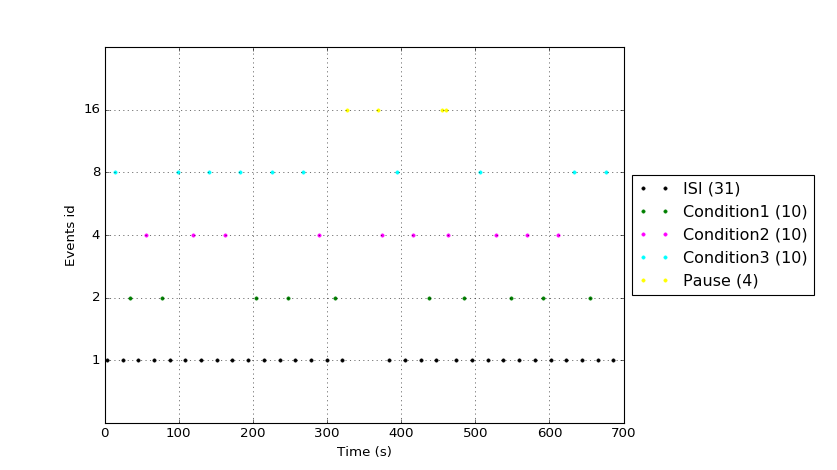

In [4]:
# Events   
events = mne.find_events(raw_data, stim_channel='Events', shortest_event=1)
event_id = {'ISI':1, 'Condition1': 2, 'Condition2': 4, 'Condition3': 8, 'Pause':16}
color = {1:'black', 2:'green', 4:'magenta', 8:'cyan', 16:'yellow'}
fig = mne.viz.plot_events(events, raw_data.info['sfreq'], raw_data.first_samp, color=color, event_id=event_id)

Sometimes we want to filter out unwanted frequencies from time series. For example, here we bandpass filter our data between 0.01 and 2 Hz.

In [5]:
# Bandpass filter raw data
l_freq = 0.01 # high-pass filter cutoff ( __/¯¯¯ )
h_freq = 2    #  low-pass filter cutoff ( ¯¯¯\__ )
    
raw_data.filter(l_freq, h_freq)

Setting up band-pass filter from 0.01 - 2 Hz
l_trans_bandwidth chosen to be 0.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 10313 samples (660.032 sec) selected


<RawArray  |  None, n_channels x n_times : 41 x 11146 (713.3 sec), ~3.6 MB, data loaded>

In order to have a general glimpse of the dataset, I start by plotting all channels into a single plot window. I choose to color-code HbO, HbR and events data using red, blue and black respectively. I also mark color-coded events positions, using the same colors previously used in `mne.viz.plot_events`.

<IPython.core.display.Javascript object>


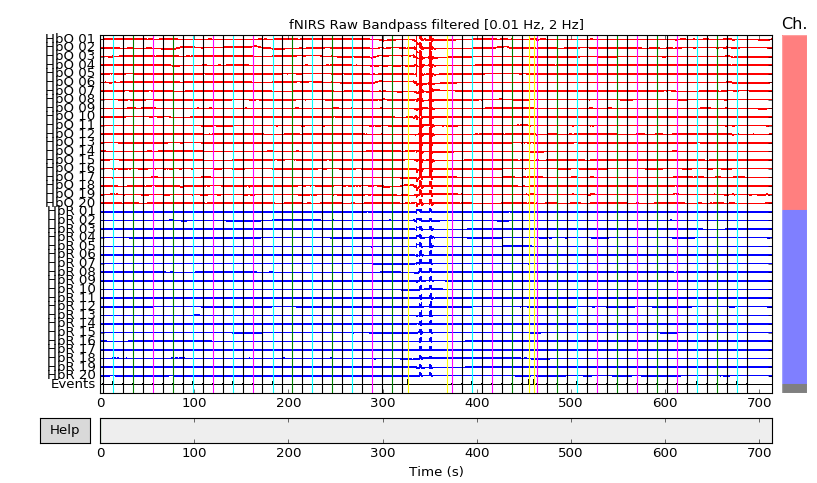

In [6]:
# Plot Raw data (all data, no scrolling)
scalings = dict(hbo=10e-6, hbr=10e-6, stim=1)
fig_title = 'fNIRS Raw Bandpass filtered [' + str(l_freq) + ' Hz, ' + str(h_freq) + ' Hz]'
plot_colors = dict(hbo='r', hbr='b', stim='k')
fig = raw_data.plot(title=fig_title, events=events, start=0.0, color=plot_colors, event_color=color, 
                    duration=np.max(raw_data.times), scalings=scalings, order='original', 
                    n_channels=len(channel_names), remove_dc=False, highpass=None, lowpass=None)

I can later dive into the dataset and look at the raw time series more closely. Same color-codes through the plots is usually a good idea.

<IPython.core.display.Javascript object>


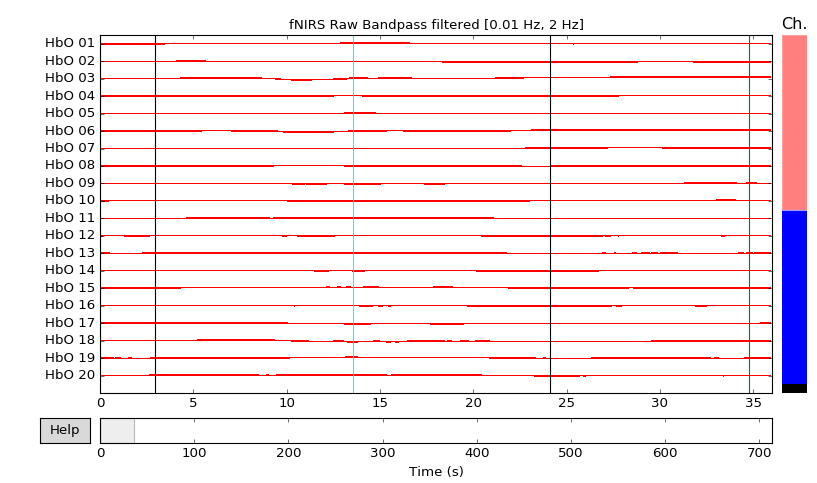

In [7]:
# Plot Raw data (default)
scalings = dict(hbo=10e-6, hbr=10e-6, stim=1)
fig_title = 'fNIRS Raw Bandpass filtered [' + str(l_freq) + ' Hz, ' + str(h_freq) + ' Hz]'
plot_colors = dict(hbo='r', hbr='b', stim='k')
fig = raw_data.plot(title=fig_title, events=events, start=0.0, color=plot_colors, event_color=color, 
                    scalings=scalings, order='original', duration=36, 
                    remove_dc=False, highpass=None, lowpass=None)

We can now select epochs (defined as windows $[-2,10] \; s$ around events) and drop unwanted ones (in this case I drop epochs with peak-to-peak amplitude larger than 1.5e-5 $\mu M$). Finally, we display the epochs time series.

65 matching events found
0 projection items activated
Loading data for 65 events and 188 original time points ...
    Rejecting  epoch based on HBO : ['HbO 01', 'HbO 02', 'HbO 03', 'HbO 04', 'HbO 05']
1 bad epochs dropped


<IPython.core.display.Javascript object>


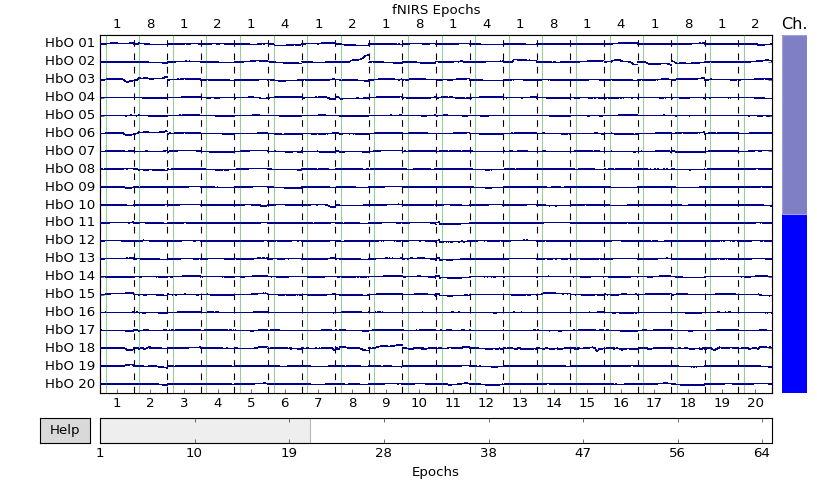

In [8]:
#%% Epochs
tmin = -2
tmax = 10
reject = dict(hbo=1.5e-5, hbr=1.5e-5)

epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True, baseline=(None, 0), preload=True, reject=reject)    

fig_title = 'fNIRS Epochs'
fig = epochs.plot(title=fig_title)

Finally, we calculate and display the evoked signals, for example the one corresponding to the first condition in the paradigm.

<IPython.core.display.Javascript object>


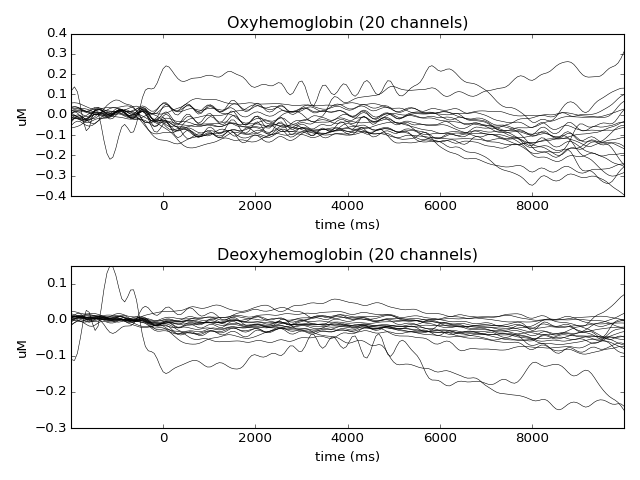

In [9]:
evoked_1 = epochs['Condition1'].average()
fig = evoked_1.plot()